In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
df = pd.read_csv("../1_Data/transformed_loan_approval_dataset.csv")

df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,total_assets,debt_to_income,loan_to_assets,cibil_bucket
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,50700000,3.114583,0.589744,2
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,17000000,2.975609,0.717647,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0,57700000,3.263736,0.514731,1
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0,52700000,3.743902,0.582543,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,55000000,2.469388,0.440000,0


In [3]:
# Split features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "../3_Api/model/scaler.pkl")


# Dictionary to store results
model_metrics = {}

In [4]:
# Helper function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }
    model_metrics[name] = metrics
    print(f"\nResults for {name}")
    for k, v in metrics.items():
        print(f"{k}: {v:.5f}")

In [5]:
# Logistic Regression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)
evaluate_model("Logistic Regression", y_test, y_pred_logreg)


Results for Logistic Regression
Accuracy: 0.90749
Precision: 0.91544
Recall: 0.93785
F1 Score: 0.92651


In [6]:
# Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
evaluate_model("Random Forest", y_test, y_pred_rf)



Results for Random Forest
Accuracy: 0.99883
Precision: 0.99812
Recall: 1.00000
F1 Score: 0.99906


In [7]:
# Support Vector Machine

svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
evaluate_model("SVM", y_test, y_pred_svm)


Results for SVM
Accuracy: 0.93911
Precision: 0.93625
Recall: 0.96798
F1 Score: 0.95185


In [8]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
evaluate_model("XGBoost", y_test, y_pred_xgb)


Results for XGBoost
Accuracy: 0.99766
Precision: 0.99812
Recall: 0.99812
F1 Score: 0.99812


C:\Users\Rohan Datta\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:54:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


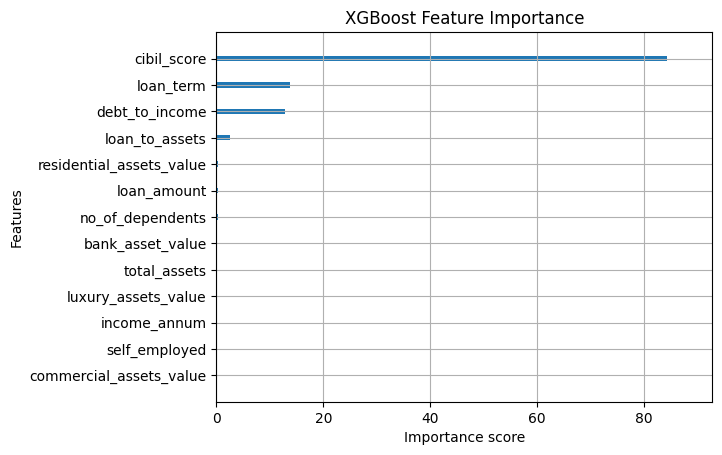

In [9]:
# Display important features used in XGBoost
xgb_model.get_booster().feature_names = X.columns.tolist()
plot_importance(xgb_model, importance_type='gain', show_values=False)
plt.title('XGBoost Feature Importance')
plt.show()

In [10]:
# Feedforward Neural Network

# Define NN architecture
nn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),  # Input + Hidden Layer 1
    Dropout(0.3),  # Optional: Dropout to reduce overfitting
    Dense(32, activation='relu'),  # Hidden Layer 2
    Dense(1, activation='sigmoid')  # Output Layer for binary classification
])

# Compile the model
nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train Neural Network
history = nn.fit(X_train_scaled, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1)



Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6904 - loss: 0.5865 - val_accuracy: 0.8770 - val_loss: 0.3193
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8808 - loss: 0.3051 - val_accuracy: 0.8931 - val_loss: 0.2619
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8858 - loss: 0.2563 - val_accuracy: 0.8990 - val_loss: 0.2422
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9204 - loss: 0.2026 - val_accuracy: 0.9048 - val_loss: 0.2227
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9174 - loss: 0.1979 - val_accuracy: 0.9151 - val_loss: 0.2057
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9113 - loss: 0.1973 - val_accuracy: 0.9136 - val_loss: 0.1944
Epoch 7/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9290 - loss: 0.1659 - val_accuracy: 0.9165 - val_loss: 0.1859
Epoch 8/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9223 - loss: 0.1590 - val_accuracy: 0.9224 - val_loss:

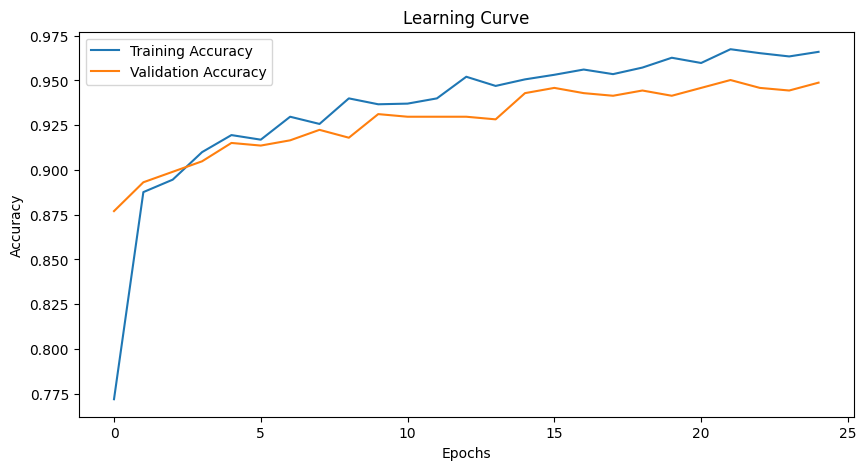

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


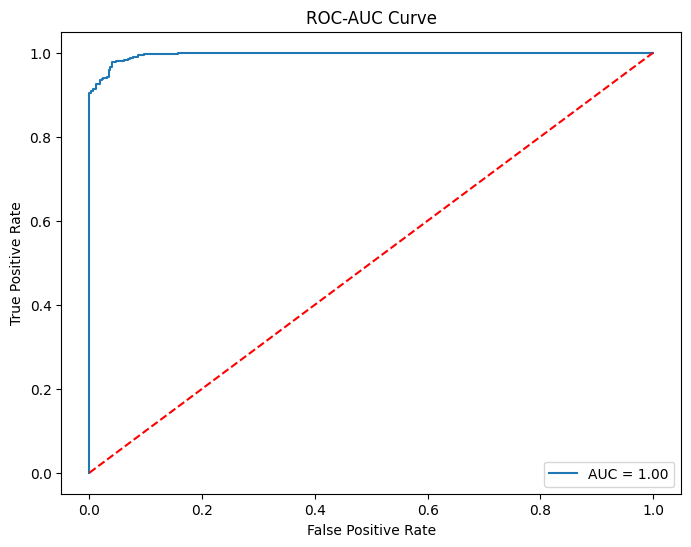

In [11]:
# Plot Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot AUC Curve for Neural Network
y_pred_prob = nn.predict(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

In [12]:
# Evaluate Neural Network
y_pred_ann = (nn.predict(X_test_scaled) > 0.5).astype("int32").flatten()
evaluate_model("Neural Network", y_test, y_pred_ann)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Results for Neural Network
Accuracy: 0.96370
Precision: 0.95956
Recall: 0.98305
F1 Score: 0.97116


In [13]:
# Plot All Model Results
results_df = pd.DataFrame(model_metrics).T
print(results_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.907494   0.915441  0.937853  0.926512
Random Forest        0.998829   0.998120  1.000000  0.999059
SVM                  0.939110   0.936248  0.967985  0.951852
XGBoost              0.997658   0.998117  0.998117  0.998117
Neural Network       0.963700   0.959559  0.983051  0.971163


In [14]:
cm_logreg = confusion_matrix(y_true, y_pred_logreg)
cm_rf     = confusion_matrix(y_true, y_pred_rf)
cm_svm    = confusion_matrix(y_true, y_pred_svm)
cm_xgb    = confusion_matrix(y_true, y_pred_xgb)
cm_nn     = confusion_matrix(y_true, y_pred_nn)

cms = [cm_logreg, cm_rf, cm_svm, cm_xgb, cm_nn]
titles = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Neural Network']

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

for i, cm in enumerate(cms):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

NameError: name 'y_true' is not defined

In [ ]:
# Plot Model Performance Comparison
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import joblib

model_filename = "../3_Api/model/random_forest_model.pkl"  # This saves the model in folder
joblib.dump(rf, model_filename)

print(f"Model saved successfully as {model_filename}")


In [ ]:
df['loan_status'].value_counts(normalize=True)
